## From Quantile Regression to Quantile Random Forests

In [106]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 
from sklearn import metrics

%matplotlib inline

from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


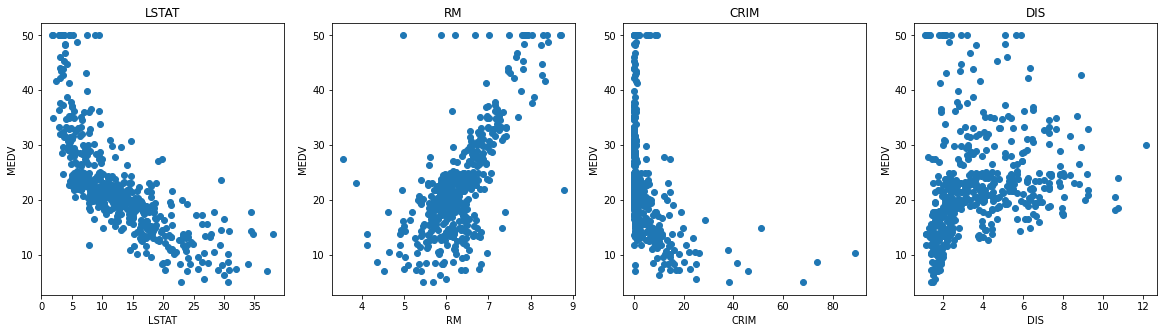

In [3]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM','CRIM','DIS']
target = boston_dataset.target

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [107]:
from sklearn import preprocessing
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)

# Standardize the variables
# It is not necessary to standardize the target. I do it just for convenience.
X_scaled = pd.DataFrame(preprocessing.scale(boston))
Y_scaled = preprocessing.scale(boston_dataset.target)
X_scaled.columns = boston.columns

### OLS

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size = 0.2, random_state=5)

OLS = LinearRegression()
OLS.fit(X_train, Y_train)

# model evaluation for testing set
y_test_predict = OLS.predict(X_test)
r2 = metrics.r2_score(Y_test, y_test_predict).round(2)
print('R2 score is {}'.format(r2) )

R2 score is 0.73


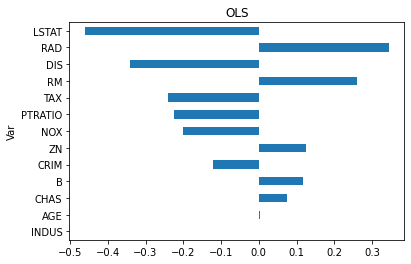

In [109]:
# Plot the coefficients in descending order
w = pd.DataFrame()
w['Var'] = X_train.columns
w = w.set_index('Var') # Set the variable names as the index
w['beta'] = OLS.coef_
w['beta_abs'] = np.abs(w['beta']) # Get the absolute value for ranking
w = w.sort_values(by='beta_abs')
w['beta'].plot.barh()
plt.title('OLS')
fig.tight_layout()
plt.show()

## Quantile Regression

In [110]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.quantile_regression as Q_reg
import matplotlib.pyplot as plt

In [34]:
quantiles = [0.01, 0.05, 0.50, 0.95 , 0.99]

# Get the model, the cofficients and the predictions in (a) - (c)
def Qreg(q):
   # (a) Modeling 
   mod = Q_reg.QuantReg(Y_train, X_train).fit(q=q)
    
   # (b) Get the coefficients and the lower and upper bounds
   coefs = pd.DataFrame()
   coefs['param'] = mod.params
   coefs = pd.concat([coefs,mod.conf_int()],axis=1) # "mod.conf_int" will give the lower and upper bounds
   coefs['q'] = q
   coefs.columns = ['beta','beta_lower','beta_upper','quantile']
    
   # (c) Predictions
   pred = pd.Series(mod.predict(X_test).round(2))
   return coefs, pred

Qreg_coefs = pd.DataFrame()
Qreg_actual_pred = pd.DataFrame()

# Get the actual and quantile predictions
for q in quantiles:
    coefs, pred = Qreg(q)
    Qreg_coefs = pd.concat([Qreg_coefs,coefs])
    Qreg_actual_pred = pd.concat([Qreg_actual_pred,pred],axis=1)

Qreg_actual_pred.columns=quantiles
Qreg_actual_pred['actual'] = Y_test
Qreg_actual_pred['interval'] = Qreg_actual_pred[0.99] - Qreg_actual_pred[0.01]
Qreg_actual_pred = Qreg_actual_pred.sort_values('interval')
Qreg_actual_pred

,0.01,0.05,0.5,0.95,0.99,actual,interval
163,2.09,2.09,1.78,1.62,1.62,2.989460,-0.47
490,-1.70,-1.69,-1.91,-1.99,-1.99,-1.570830,-0.29
489,-1.29,-1.28,-1.49,-1.56,-1.57,-1.690551,-0.28
273,1.47,1.47,1.31,1.22,1.23,1.378665,-0.24
140,-0.59,-0.59,-0.75,-0.82,-0.82,-0.928689,-0.23
...,...,...,...,...,...,...,...
403,-1.28,-1.27,-1.15,-1.08,-1.08,-1.549063,0.20
410,-1.64,-1.64,-1.50,-1.43,-1.43,-0.819852,0.21
66,0.22,0.23,0.40,0.48,0.48,-0.340967,0.26
292,0.92,0.92,1.10,1.18,1.19,0.584152,0.27


In [131]:
r2 = metrics.r2_score(Qreg_actual_pred['actual'], Qreg_actual_pred[0.5]).round(2)
print('R2 score is {}'.format(r2) )

R2 score is 0.75


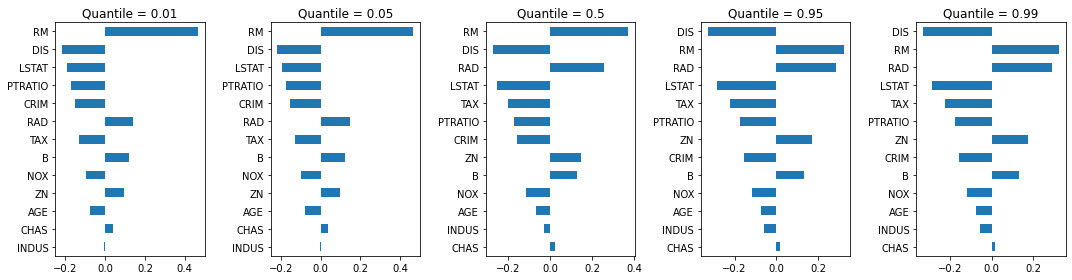

In [123]:
# Get the absolute value of the coefficients for ranking
Qreg_coefs['beta_abs'] = np.abs(Qreg_coefs['beta'] ) 
Qreg_coefs = Qreg_coefs.sort_values(by=['quantile','beta_abs'])

fig = plt.figure(figsize=(15, 4))

n = len(quantiles)

for i in range(n):
    plt.subplot(1, n, i+1)
    w = Qreg_coefs[Qreg_coefs['quantile']==quantiles[i]]
    w['beta'].plot.barh()
    plt.title('Quantile = ' + str(quantiles[i] ))

fig.tight_layout()
plt.show()

## Quantile Gradient Boosting

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
quantiles = [0.01, 0.05, 0.50, 0.95 , 0.99]

# Get the model and the predictions in (a) - (b)
def GBM(q):
    
   # (a) Modeling  
   mod = GradientBoostingRegressor(loss='quantile', alpha=q,
                                n_estimators=500, max_depth=8,
                                learning_rate=.01, min_samples_leaf=20,
                                min_samples_split=20)
   mod.fit(X_train, Y_train)

   # (b) Predictions
   pred = pd.Series(mod.predict(X_test).round(2))
   return pred, mod

GBM_models=[]
GBM_actual_pred = pd.DataFrame()

for q in quantiles:
    pred , model = GBM(q)
    GBM_models.append(model)
    GBM_actual_pred = pd.concat([GBM_actual_pred,pred],axis=1)

GBM_actual_pred.columns=quantiles
GBM_actual_pred['actual'] = Y_test
GBM_actual_pred['interval'] = GBM_actual_pred[np.max(quantiles)] - GBM_actual_pred[np.min(quantiles)]
GBM_actual_pred = GBM_actual_pred.sort_values('interval')
GBM_actual_pred

,0.01,0.05,0.5,0.95,0.99,actual,interval
46,-1.70,-1.85,-1.58,-0.36,-0.52,-1.690551,1.18
16,-1.72,-1.65,-1.16,-0.14,-0.52,-0.504223,1.20
65,-1.43,-1.48,-1.38,-0.21,0.25,-1.549063,1.68
5,-1.68,-1.70,-1.52,-0.30,0.25,-1.320504,1.93
37,-1.70,-1.69,-1.57,-0.34,0.25,-1.549063,1.95
...,...,...,...,...,...,...,...
12,-0.86,-0.48,-0.24,0.24,2.99,-0.243013,3.85
63,-0.86,-0.49,1.37,1.00,2.99,2.042574,3.85
7,-0.86,-0.32,0.35,0.60,2.99,0.703873,3.85
100,-0.89,-0.46,-0.14,0.29,2.99,0.050848,3.88


In [132]:
r2 = metrics.r2_score(GBM_actual_pred['actual'], GBM_actual_pred[0.5]).round(2)
print('R2 score is {}'.format(r2) )

R2 score is 0.89


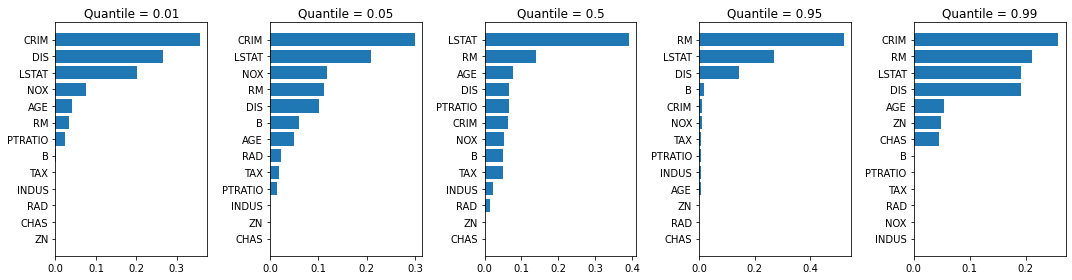

In [12]:
fig = plt.figure(figsize=(15, 4))

n = len(quantiles)

for i in range(n):
    plt.subplot(1, n, i+1)
    feature_importance = GBM_models[i].feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(boston.columns)[sorted_idx])
    plt.title('Quantile = ' + str(quantiles[i] ))

fig.tight_layout()
plt.show()

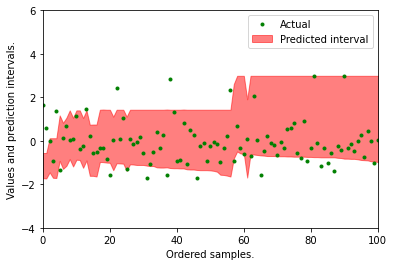

In [13]:
plt.plot(GBM_actual_pred['actual'],'go',markersize=3,label='Actual')
plt.fill_between(
    np.arange(GBM_actual_pred.shape[0]), GBM_actual_pred[0.01], GBM_actual_pred[0.99], alpha=0.5, color="r",
    label="Predicted interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 100])
plt.ylim([-4, 6])
plt.legend()
plt.show()

In [102]:
def correctPcnt(actual_pred):
    correct = 0
    for i in range(actual_pred.shape[0]):
        if actual_pred.loc[i,0.01] <= actual_pred.loc[i,'actual'] <= actual_pred.loc[i,0.99]:
            correct += 1
    print(correct/len(Y_test))
    
    
correctPcnt(GBM_actual_pred)

0.9607843137254902


### Quantile Random Forests

In [74]:
# random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=0,min_samples_split=10)
rf.fit(X_train, Y_train)

RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=0)

In [93]:
# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees
pred_Q = pd.DataFrame()
for pred in rf.estimators_:
    temp = pd.Series(pred.predict(X_test).round(2))
    pred_Q = pd.concat([pred_Q,temp],axis=1)
pred_Q.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2.87,2.99,2.39,2.40,2.91,2.76,2.52,2.80,2.56,2.60,...,2.20,2.24,2.28,2.56,2.99,1.96,2.99,2.90,2.44,2.61
1,0.48,0.39,0.16,1.04,0.39,0.56,0.42,0.65,1.38,0.93,...,0.86,0.38,0.86,0.70,1.06,0.73,0.71,0.62,1.08,0.09
2,-0.02,0.02,0.11,-0.08,0.06,0.10,0.12,0.11,-0.07,-0.06,...,-0.02,0.29,-0.01,0.06,0.10,0.22,-0.03,0.31,0.09,0.14
3,-1.18,-0.95,-1.29,-1.23,-1.31,-0.95,-1.04,-1.05,-1.36,-1.56,...,-0.98,-0.72,-1.74,-1.68,-1.10,-1.20,-1.62,-1.03,-1.01,-1.09
4,2.47,1.31,2.08,2.40,2.32,2.34,2.00,1.84,0.99,2.96,...,2.20,1.36,2.28,2.56,1.18,2.52,1.05,2.25,2.44,2.61


In [95]:
RF_actual_pred = pd.DataFrame()

for q in quantiles:
    s = pred_Q.quantile(q=q, axis=1)
    RF_actual_pred = pd.concat([RF_actual_pred,s],axis=1,sort=False)
   
RF_actual_pred.columns=quantiles
RF_actual_pred['actual'] = Y_test
RF_actual_pred['interval'] = RF_actual_pred[np.max(quantiles)] - RF_actual_pred[np.min(quantiles)]
RF_actual_pred = RF_actual_pred.sort_values('interval')
RF_actual_pred = RF_actual_pred.round(2)
RF_actual_pred

,0.01,0.05,0.5,0.95,0.99,actual,interval
11,-0.46,-0.40,-0.28,0.00,0.15,-0.38,0.61
100,-0.46,-0.41,-0.18,0.00,0.17,0.05,0.63
27,-0.50,-0.44,-0.32,0.01,0.13,-0.15,0.63
5,-1.80,-1.75,-1.61,-1.39,-1.15,-1.32,0.65
26,-0.06,0.01,0.16,0.31,0.61,0.06,0.67
...,...,...,...,...,...,...,...
74,-1.05,-0.84,2.99,2.99,2.99,0.58,4.04
33,-1.32,-1.07,-0.72,2.99,2.99,-0.52,4.31
92,-1.33,-0.83,-0.21,0.00,2.99,-0.12,4.32
19,-1.34,-1.17,-0.00,2.99,2.99,-0.82,4.33


In [133]:
r2 = metrics.r2_score(RF_actual_pred['actual'], RF_actual_pred[0.5]).round(2)
print('R2 score is {}'.format(r2) )

R2 score is 0.81


In [103]:
correctPcnt(RF_actual_pred)

0.9509803921568627
